A basic analysis of my results data downloaded from Transcriptic. 
The protocol was generated with [Autodesk Wet Lab Accelerator](https://wla.bionano.autodesk.com/#/). 

An *E. coli* strain (Zymo10B) is transformed with a luciferase-expressing plasmid (PVIB) in a 96 well plate. 

Each row (A-H) is identical and each column (1-6) is different:

    [A-H]1 : E coli + PVIB + no amp broth
    [A-H]2 : E coli + no PVIB + no amp broth
    [A-H]3 : no amp broth
    [A-H]4 : E coli + PVIB + amp broth (i.e., luciferase expression)
    [A-H]5 : E coli + amp broth
    [A-H]6 : amp broth

For rows A-F, absorbance (OD600) and luminescence (to see luciferase expression) are captured once an hour for 18 hours.

Rows G and H are transferred to two "6-flat" plates, one without amp (G), one with amp (H). 
For each of the two sets of 6 plates a photo is taken, then the plates are incubated for 18 hours, then another photo is taken.

In [496]:
# Setup cell
from __future__ import print_function, division

import string
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from functools import partial
from IPython.display import display, HTML, SVG

def uprint(astr): print(astr + "\n" + "-"*len(astr))
def show_html(astr): return display(HTML('{}'.format(astr)))
def show_svg(astr, w=1000, h=1000):
    SVG_HEAD = '''<?xml version="1.0" standalone="no"?><!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN" "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">'''
    SVG_START = '''<svg width="{w:}px" height="{h:}px" version="1.1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink= "http://www.w3.org/1999/xlink">'''
    return display(SVG(SVG_HEAD + SVG_START.format(w=w, h=h) + astr + '</svg>'))

# Plotting style, matplotlib and seaborn
plt.rc("axes", titlesize=20, labelsize=15, linewidth=.25, edgecolor='#444444')
sns.set_context("notebook", font_scale=1.2, rc={})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Read in files
=======
Absorbance and luminescence files from all plates were downloaded as csv files from transcriptic.

In [473]:
import glob
abs_files = sorted(glob.glob("absorbance_*.csv"), key=lambda x: (len(x), x))
lum_files = sorted(glob.glob("luminescence_*.csv"), key=lambda x: (len(x), x))
print("{} absorbance files:  ".format(len(abs_files)), abs_files[::5])
print("{} luminescence files:".format(len(lum_files)), lum_files[::5])

18 absorbance files:   ['absorbance_18.csv', 'absorbance_43.csv', 'absorbance_68.csv', 'absorbance_93.csv']
18 luminescence files: ['luminescence_19.csv', 'luminescence_44.csv', 'luminescence_69.csv', 'luminescence_94.csv']


Dataframes
======
Read absorbance and luminescence data into pandas dataframes. 

The time at which readings were taken is not included in the csv files (only another json file), but since I know readings were taken once per hour, I can simply increment the time myself.

In [498]:
import datetime

abs_data = [pd.read_csv(abs_file, index_col="Well") for abs_file in abs_files]
lum_data = [pd.read_csv(lum_file, index_col="Well") for lum_file in lum_files]

times = range(len(abs_data)) # or get the true time from the json file

# Each file is for a specific time. Concatenate all the files and reset the index
df_abs = pd.concat(abs_data, keys=times, names=["Time","Well"])
df_abs.reset_index(inplace=True)

df_lum = pd.concat(lum_data, keys=times, names=["Time","Well"])
df_lum.reset_index(inplace=True)

print(df_abs.head())
print()
print(df_lum.tail())

   Time Well  OD 600:nanometer
0     0   A1          0.047956
1     0   A2          0.049607
2     0   A3          0.046221
3     0   A4          0.047077
4     0   A5          0.048022

     Time Well  Luminescence
643    17   F2             5
644    17   F3            18
645    17   F4            12
646    17   F5             5
647    17   F6            19


Plot
===
Plot absorbance and luminescence data for each of the 48 wells using SVG.

In [493]:
well_params = {"1":["E coli", "PVIB"], "2":["E coli"], "3":[],
               "4":["E coli","PVIB","amp"], "5":["E coli", "amp"], "6":["amp"]}

def to_coords(w, h, min_x, max_x, min_y, max_y, x, y): 
    return w*(x-min_x)/(max_x-min_x), h-h*(y-min_y)/(max_y-min_y)

def plot_df(df, x_col, y_col, wh=100):
    w, h = wh, wh
    sw, sh = w*1.2, h*1.2
    mx, my = w*.1, h*.1
    
    # min, max over all plates
    min_x, max_x = df[x_col].min(), df[x_col].max()
    min_y, max_y = df[y_col].min(), df[y_col].max()
    wells = set(df["Well"])
    num_rows = 1 + max(string.uppercase.index(well[0]) for well in wells)
    num_cols = max(int(well[1]) for well in wells)
    
    _to_coords = partial(to_coords, w, h, min_x, max_x, min_y, max_y)
    
    g = df.groupby("Well")    
    ssvg = '<g transform="translate({},{})">'.format(w/2, h/2)
    for n, (key, _df) in enumerate(g):
        vals = _df[[x_col, y_col]].values
        
        cx = mx + sw * (int(key[1])-1) # well number (1-6) is the column
        cy = my + sh * string.uppercase.index(key[0]) # well letter (A-F) is the row
        
        ssvg += '''<circle cx="{cx:f}" cy="{cy:f}" r="{r:f}" stroke="rgba(0,0,0,.15)" fill="none" 
                   />'''.format(cx=cx, cy=cy, r=w/2)

        # Text labels for the plates
        ssvg += '''<text x="{cx:f}" y="{cy:f}" text-anchor="middle" font-size="20" fill="rgba(0,0,0,.25)">{text:}
                   </text>'''.format(cx=cx, cy=cy, text=key)

        if "E coli" in well_params[key[1]]:
            ssvg += '''<text x="{cx:f}" y="{cy:f}" text-anchor="middle" font-size="12" fill="rgba(0,200,0,.25)">E coli
                       </text>'''.format(cx=cx, cy=cy+12)

        if "PVIB" in well_params[key[1]]:
            ssvg += '''<text x="{cx:f}" y="{cy:f}" text-anchor="middle" font-size="12" fill="rgba(0,0,200,.25)">PVIB
                       </text>'''.format(cx=cx, cy=cy+24)

        if "amp" in well_params[key[1]]:
            ssvg += '''<text x="{cx:f}" y="{cy:f}" text-anchor="middle" font-size="12" fill="rgba(200,0,0,.25)">amp
                       </text>'''.format(cx=cx, cy=cy-24)

        # Plot the absorbance/luminescence x/y values as a line
        points = ' '.join(','.join(map(str, _to_coords(x,y))) for x,y in vals)
        ssvg += '<g transform="translate({},{})">'.format(cx-w*.5, cy-h*.5)
        ssvg += '''<polyline points="{points:}" style="fill:none;stroke:rgba(100,140,180,1);stroke-width:2" 
                   />'''.format(points=points)
        ssvg += '</g>'
    
    ssvg += '</g>'
    show_html("<h1>{}</h1>".format(y_col))
    show_svg(ssvg, w=sw*num_cols, h=sh*num_rows)

Absorbance
=====
The absorbance data shows the growth of the *E. coli* and generally looks good. 
We expect growth in columns 1 and 2 for sure, and column 4 if the transformation works.

We see growth in columns 1 and 2, as expected. 
In three out of six wells in column 4 we see growth (i.e., 50% transformation efficiency). 
In these wells the *E. coli* have taken up PVIB so they can resist ampicillin.

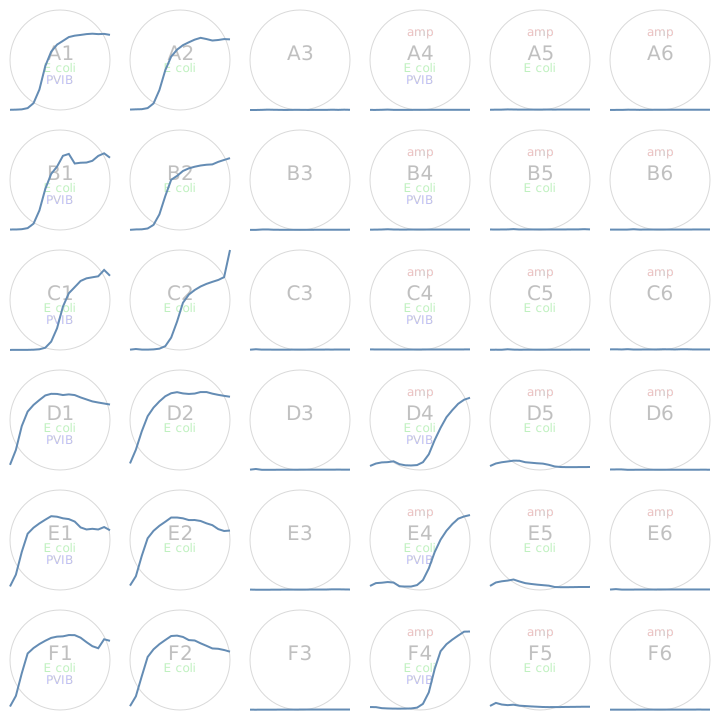

In [494]:
plot_df(df_abs, "Time", "OD 600:nanometer")

Luminescence
======
The luminescence data show the success of the PVIB plasmid transforming *E. coli* and expressing luciferase.
We only expect luminescence in column 4, since that is the only column with PVIB and ampicillin.
We detect luminescence in only one of three transformed *E. coli*.

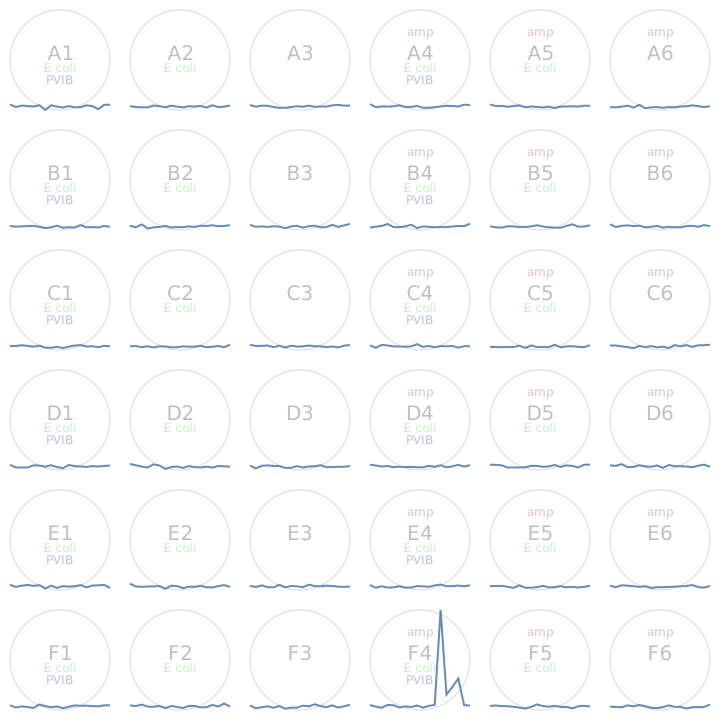

In [482]:
plot_df(df_lum, "Time", "Luminescence")

Image Capture
=======
Finally, we take photos of *E. coli* growing in plates, before and after incubation. 

    G plates have no amp, H plates have amp
    [GH]1 has E. coli and PVIB
    [GH]2 has E. coli and no PVIB
    [GH]3 has no E. coli

That the H plates are all empty is not surprising because we know from the experiment above that PVIB transformation is not efficient. There is something strange going on here with the Gs though, 
where G3 is showing growth despite having no *E. coli* spread, while G1 has no growth when it should.

I am currently assuming the images are reversed from what I expect, but I don't know why... The Transcriptic UI is quite explicit about which plate is which.

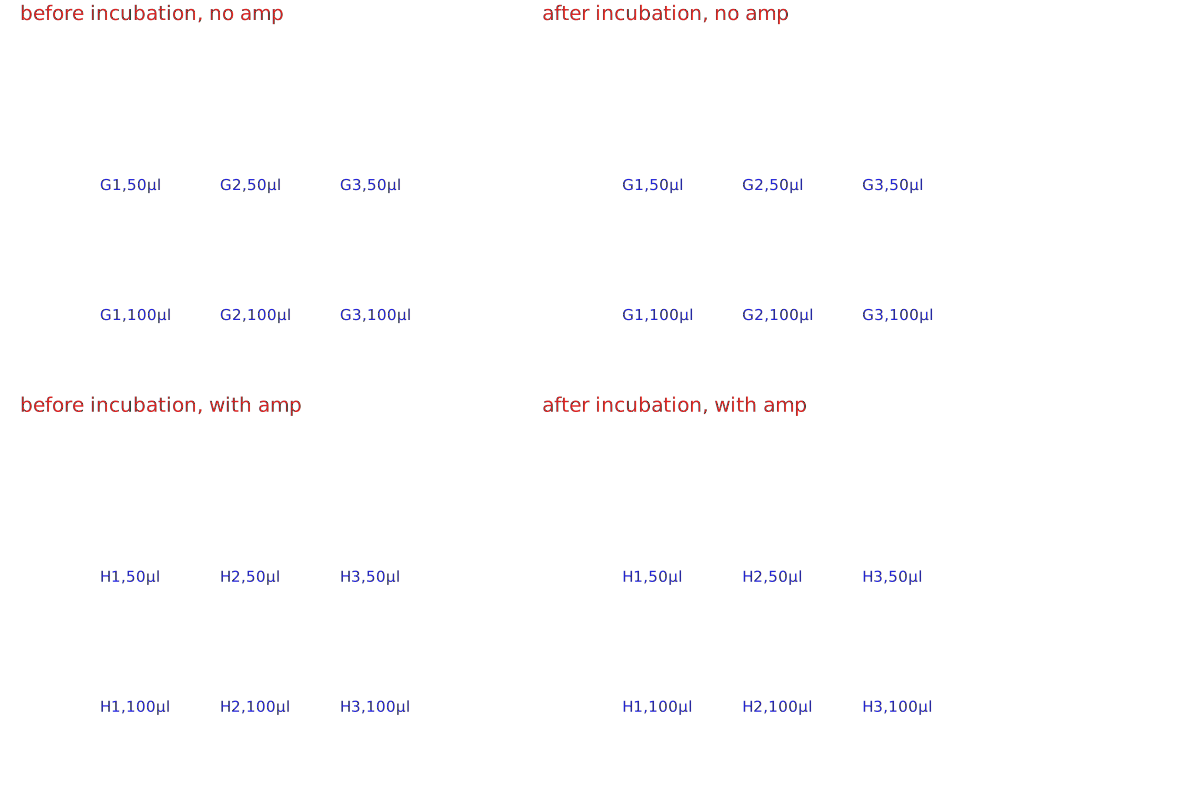

In [485]:
data = [{'n':'108', 'desc':'before incubation, no amp', 'plates':['G1,50','G2,50','G3,50','G1,100','G2,100','G3,100']},
        {'n':'112', 'desc':'after incubation, no amp', 'plates':['G1,50','G2,50','G3,50','G1,100','G2,100','G3,100']},
        {'n':'113', 'desc':'before incubation, with amp', 'plates':['H1,50','H2,50','H3,50','H1,100','H2,100','H3,100']},
        {'n':'117', 'desc':'after incubation, with amp', 'plates':['H1,50','H2,50','H3,50','H1,100','H2,100','H3,100']}
        ]

w, h = 512, 384 # hardcoded image size
sw, sh = w*1.02, h*1.02
mx, my = 100, 190
px, py = 120, 130

ssvg = ''
for n, d in enumerate(data):
    ssvg += '<g transform="translate({},{})">'.format(sw*(n%2), sh*(n//2))
    ssvg += '''<image xlink:href="imagePlate_{}.png" x="0" y="0" width="{}px" height="{}px"
               />'''.format(d['n'], w, h)
    ssvg += '<text x="20" y="20" fill="#dd2222" font-size="20">{}</text>'.format(d['desc'])
    for n2, pl in enumerate(d["plates"]):
        ssvg += '''<text x="{}" y="{}" fill="#2222dd" font-size="15">{}μl
                   </text>'''.format(mx+px*(n2%3), my+py*(n2//3), pl)
    ssvg += '</g>'
show_svg(ssvg, w=1200, h=800)

Conclusion
======
I think this experiment was moderately successful. 
It was not that expensive at about \$20 for labor and \$35 for reagents.
The transformation and luciferase expression efficiency was pretty low, but I don't know what I'd expect if the experiment were performed by a skilled technician. 

There were a few minor issues on the Transcriptic side:

    - The PNG images get downloaded as .raw files. Initially, I thought it was a camera RAW file, which didn't work...
    - The UI mixes 0-indexing and 1-indexing, which is a bit confusing. I would enforce 1-indexing.
    - The plate images may be reversed compared to the UI? This could be an error on my part though.
    - The "Download all" feature did not download all the data (it missed the images).
    - The csv files did not include the time at which readings were taken. I'd have to dig into the json files to get that.